In [55]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bk-agg-features-data/train_agg_320_feats_no_corr_no_target.pkl
/kaggle/input/bk-agg-features-data/test_agg_320_feats_no_corr.pkl
/kaggle/input/bk-new-aggr-features/new_train_aggr_features.pkl
/kaggle/input/bk-new-aggr-features/new_test_aggr_features.pkl
/kaggle/input/international-cp/parsing_categories.csv
/kaggle/input/international-cp/submission.csv
/kaggle/input/international-cp/data/new_train_features.pkl
/kaggle/input/international-cp/data/train_dataset_hackaton2023_train.gzip
/kaggle/input/international-cp/data/hackaton2023_test.gzip
/kaggle/input/international-cp/data/new_test_features.pkl
/kaggle/input/international-cp/grouped_train/grouped_train.pkl


In [56]:
import time
import numpy as np
import pandas as pd
import math
import tqdm
import tqdm.notebook as tqdm_nb
import tqdm.auto as tqdm_a
from termcolor import colored
from functools import partial
from IPython.display import display

import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (f1_score, precision_score, recall_score,
                             roc_auc_score, roc_curve, auc, precision_recall_curve, confusion_matrix, accuracy_score
                            )
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.cluster import SpectralClustering
from sklearn.inspection import permutation_importance

import scipy.stats as sps
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier

import lightgbm as lgb

In [57]:
def plot_roc_curve(y, proba, sec_limits=None, label='', color='C0', fig=None, ax=None, return_figure=False):
    fpr, tpr, _ = roc_curve(y, proba)
    area = auc(fpr, tpr)
    
    # fig, ax = check_figax(fig, ax)
    fig.subplots_adjust(hspace=0.1)
    
    ax.plot(fpr, tpr, lw=2, color=color, label=f'{label} auc: {area:.5f}')
    ax.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    
    if sec_limits is None:
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.0])
    else:
        ax.set_xlim(sec_limits[0])
        ax.set_ylim(sec_limits[1])
        
    ax.set_xlabel('False Positive Rate', fontsize=14)
    ax.set_ylabel('True Positive Rate', fontsize=14)
    ax.set_title('ROC curve', fontsize=15)
    ax.legend(loc='center right', fontsize=12)
    ax.grid()
    
    if return_figure: return fig


def plot_pr_curve(y, proba, sec_limits=None, label='', color='C0', fig=None, ax=None, return_figure=False):
    prec, rec, thres = precision_recall_curve(y, proba)
    area = auc(rec, prec)
    
    # fig, ax = check_figax(fig, ax)
    
    ax.plot(rec, prec, lw=2, color=color, label=f'{label} auc: {area:.5f}')
    
    if sec_limits is None:
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.0])
    else:
        ax.set_xlim(sec_limits[0])
        ax.set_ylim(sec_limits[1])
        
    ax.set_xlabel('Recall', fontsize=14)
    ax.set_ylabel('Precision', fontsize=14)
    ax.set_title('PR curve', fontsize=15)
    ax.legend(loc='center right', fontsize=12)
    ax.grid()
    
    if return_figure: return fig

def plot_confusion(y, pred_label, fig=None, ax=None, return_figure=False, fmt='d'):
    cm = confusion_matrix(y, pred_label)
    
    if ax is None:  # Check if ax is None, and if so, create a new figure and ax.
        fig, ax = plt.subplots(figsize=(8, 8))
        
    ax.set_title('Confusion matrix')
    sns.heatmap(cm, annot=True, cmap='Blues', ax=ax, fmt=fmt)
    
    ax.set_xlabel('\nPredicted values')
    ax.set_ylabel('\nActual values')
    
    if return_figure: return fig

def find_best_threshold(y, proba, method='f1'):
    if method == 'f1':
        prec, rec, thres = precision_recall_curve(y, proba, pos_label=1)
        f1 = 2 * prec * rec / (prec + rec)
        ind = np.nanargmax(f1)
        best_thres = thres[ind]
        
    elif method == 'J':
        fpr, tpr, thres = roc_curve(y, proba, pos_label=1)
        J = tpr - fpr
        ind = np.nanargmax(J)
        best_thres = thres[ind]
        
    return best_thres


def predict_proba_4eval_sets(clf, eval_sets):
    target_proba_sets = list()
    lst_feats = clf.feature_name_
    for i in range(len(eval_sets)):
        X, y = eval_sets[i]
        target_proba_sets.append((y, clf.predict_proba(X[lst_feats])[:, 1]))
        
    return target_proba_sets

def get_metrics_clf(target_proba_sets, eval_names, thres_method='f1'):
    n = len(target_proba_sets)
    metrics_df = list()
    
    for i in range(n):
        y, proba = target_proba_sets[i]
        name = eval_names[i]
        best_thres = find_best_threshold(y, proba, thres_method)
        pred_label = np.where(proba > best_thres, 1, 0)
        
        acc = accuracy_score(y, pred_label)
        f1 = f1_score(y, pred_label)
        prec = precision_score(y, pred_label)
        rec = recall_score(y, pred_label)
        roc_auc = roc_auc_score(y, proba)
        metrics_df.append(pd.DataFrame({'sample': [name],
                                        'roc_auc': [roc_auc],
                                        'Best thres': [best_thres],
                                        'F1': [f1],
                                        'Prec': [prec],
                                        'Rec': [rec]}))
    metrics_df = pd.concat(metrics_df, ignore_index=True)
    
    return metrics_df


def evaluation_clf(target_proba_sets, eval_names, roc_limits=None, pr_limits=None, thres_method='f1'):
    n = len(target_proba_sets)
    colors = [f'C{i}' for i in range(n)]
    
    fig, ax = plt.subplots(ncols=2, figsize=(10,4))
    ax1, ax2 = ax.ravel()
    
    metrics_df = get_metrics_clf(target_proba_sets, eval_names)
    
    for i in range(n):
        y, proba = target_proba_sets[i]
        name = eval_names[i]
        color = colors[i]
        
        best_thres = find_best_threshold(y, proba, thres_method)
        pred_label = np.where(proba > best_thres, 1, 0)
        
        plot_roc_curve(y, proba, label=name, color=color, sec_limits=roc_limits, fig=fig, ax=ax1, return_figure=False)
        fig = plot_pr_curve(y, proba, label=name, color=color, sec_limits=pr_limits, fig=fig, ax=ax2, return_figure=True)
        
    return fig, metrics_df



In [58]:
def build_cb_model(X_train, y_train, X_valid, y_valid, params=None, cat_features=[], 
                   verbose=50, seed=15, n_jobs=-1, fit_kwargs=None, task_type='binary'):
    params = {} if params is None else params.copy()
    params['verbose'] = params.get('verbose', verbose)
    params['random_state'] = params.get('random_state', seed)
    params['n_jobs'] = params.get('n_jobs', n_jobs)
    
    fit_kwargs = {} if fit_kwargs is None else fit_kwargs.copy()

    # Determine the model type
    if task_type == 'binary':
        model = LGBMClassifier(**params)
    elif task_type == 'regression':
        model = LGBMRegressor(**params)
    else:
        raise ValueError('task_type should be either "binary" or "regression"')
    
    # Fit the model
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid), **fit_kwargs)

    return model



def get_feature_importance(model):
    imp = pd.Series(model.feature_importances_,
                   index=model.feature_name_)\
                         .sort_values(ascending=False)\
                         .to_frame()\
                         .reset_index()\
                         .rename(columns={'index': 'feat_name', 0: 'feat_imp'})
    return imp

def plot_feature_importance(model, top_n=None, figsize=None):
    imp = get_feature_importance(model)
    
    fig, ax = plt.subplots(figsize=figsize or (12, 6))
    imp.set_index('feat_name')\
            .sort_values(by='feat_imp')\
            .tail(top_n or len(imp))\
            .plot(kind='barh', color='lightblue', ec='black', ax=ax, width=0.5)
    
    t = f"(Top: {top_n})" if top_n is not None else ""
    ax.set_title("Feature importance " + t)
    ax.grid(False, axis='y')
    
    return fig

def get_permutation_feature_importance(clf, X_test, y_test, scorer, n_repeats=10, seed=15, n_jobs=8, perm_kwargs=None):
    perm_kwargs = {}  if perm_kwargs is None else perm_kwargs.copy()
    perm_kwargs['n_repeats'] = perm_kwargs.get('n_repeats') or n_repeats
    perm_kwargs['random_state'] = perm_kwargs.get('random_state') or seed
    perm_kwargs['n_jobs'] = perm_kwargs.get('n_jobs') or n_jobs
    
    perm_result = permutation_importance(clf, X_test, y_test, scoring=scorer, **perm_kwargs)
    
    perm_imp_df = pd.DataFrame({'feat_name' : clf.feature_name_,
                                'feat_imp' : perm_result['importances_mean'],
                                'feat_imp_std' : perm_result['importances_std']})
    perm_imp_df = perm_imp_df.sort_values(by='feat_imp', ascending=False)\
                                .reset_index(drop=True)
    
    return perm_imp_df


def feat_selection_by_permutation(train_df, test_df, y_train, y_test, lst_feats=None, model_name=None, 
                                 model_params=None, scorer=None, perm_kwargs=None, add_noise_feats=True,
                                 seed=15, n_jobs=-1, fit_kwargs=None):
    model_params = {} if model_params is None else model_params.copy()
    fit_kwargs = {} if fit_kwargs is None else fit_kwargs.copy()
    perm_kwargs = {} if perm_kwargs is None else perm_kwargs.copy()
    
    lst_feats = train_df.columns.to_list() if lst_feats is None else lst_feats.copy()
    lst_cat_feats = [c for c in train_df.select_dtypes(include=['O', 'category']).columns if c in lst_feats]
    
    n_feats = len(lst_feats)
    train_df = train_df.copy()
    tets_df = test_df.copy()
    
    if add_noise_feats:
        train_df['NORMAL'] = sps.norm.rvs(loc=0, scale=1, size=len(train_df), random_state=seed)
        train_df['UNIFORM'] = sps.uniform.rvs(loc=0, scale=1, size=len(train_df), random_state=seed)
        
        test_df['NORMAL'] = sps.norm.rvs(loc=0, scale=1, size=len(test_df), random_state=seed)
        test_df['UNIFORM'] = sps.uniform.rvs(loc=0, scale=1, size=len(test_df), random_state=seed)
        lst_feats += ['NORMAL', 'UNIFORM']
        
    print(f">> Building model: {model_name}")
    start_t = time.time()
    
    if model_name == 'catboost':
        clf = build_cb_model(train_df[lst_feats], y_train, test_df[lst_feats], y_test,
                            cat_features=lst_cat_feats,
                            params=model_params,
                            verbose=0, seed=seed, n_jobs=-1, fit_kwargs=fit_kwargs)
    else:
        raise ValueError('incorrect model name')
        
    end_t = time.time()
    print(f">> Done ({end_t - start_t:.2f}s)")
    
    print(f"Start permutation", "with adding noise feats" if add_noise_feats else "", "...")
    
    perm_imp_df = get_permutation_feature_importance(clf, test_df[lst_feats], y_test, scorer, seed=seed, **perm_kwargs)
    
    if add_noise_feats:
        uniform_perm_value = perm_imp_df[perm_imp_df.feat_name == 'UNIFORM']['feat_imp'].values[0]
        normal_perm_value = perm_imp_df[perm_imp_df.feat_name == 'NORMAL']['feat_imp'].values[0]
        perm_filter = (perm_imp_df.feat_imp <= max(0, normal_perm_value, uniform_perm_value))
        perm_imp_df = perm_imp_df[~perm_filter].reset_index(drop=True)
        train_df.drop(['NORMAL', 'UNIFORM'], axis=1, inplace=True)
        test_df.drop(['NORMAL', 'UNIFORM'], axis=1, inplace=True)
    else:
        perm_filter = (perm_imp_df.feat_imp <= 0)
        perm_imp_df = perm_imp_df[~perm_filter].reset_index(drop=True)
        
    perm_imp_df = perm_imp_df.reset_index(drop=True)
    lst_sel_feats = perm_imp_df['feat_name'].to_list()
    
    end_t = time.time()
    print(f">> Done ({end_t - start_t:.2f}s)")
    print(f"Reduced number of feats: {n_feats} -> {len(lst_sel_feats)}")
    
    return perm_imp_df, lst_sel_feats

def custom_forward_selection(X_train, y_train, X_test, y_test, task_type='binary', eval_sets=None, eval_names=None,
                            lst_feats_for_select=None, cat_features=None, scorer=None, maximize_score=None, maximize_eval_name='Test',
                            metric_thres=1e-5, step=1, method='fast', reorder_init=False, model_name='catboost', model_params=None,
                             seed=15, n_jobs=-1, perm_kwargs=None, fit_kwargs=None):
    
    init_features = X_train.columns.to_list() if lst_feats_for_select is None else lst_feats_for_select
    cat_features = [] if cat_features is None else cat_features
    init_cat_features = [c for c in cat_features if c in set(init_features)]
    
    eval_sets = [(X_train, y_train), (X_test, y_test)] if eval_sets is None else eval_sets
    eval_names = ['Train', 'Test'] if eval_names is None else eval_names
    
    num_fs_steps = len(init_features)
    sign_coef = 1 if maximize_score else -1
    bad_fs_feats = []
    stop_selection_flag = False
    start_i = 0
    sel_features = []
    
    scores = {name : [] for name in eval_names}
    history = dict()
    history['metrics'] = list()
    history['scores'] = list()
    history['num_feats'] = list()
    history['sel_feats'] = list()
    history['iteration'] = list()
    
    progress = tqdm.tqdm(desc='fs_step')
    while not stop_selection_flag:
        excluded_feat = None
        
        n = len(init_features)
        n_iteration = (n + step - 1) // step
        
        for i in range(start_i, n_iteration):
            from_feat_idx = i * step
            to_feat_idx = (i + 1) * step
            feats = init_features[from_feat_idx: to_feat_idx]
            
            sel_features.extend(feats)
            print(sel_features)
            sel_cat_features = [c for c in init_cat_features if c in sel_features]
            
            print(f'--- Iteration: {i}. Number of feats: {to_feat_idx}/{n} ---')
            print(f'>> Building model: {model_name}')
            start_t = time.time()
            
            clf = build_cb_model(X_train[sel_features], y_train, 
                                     X_test[sel_features], y_test,
                                     cat_features=sel_cat_features, params=model_params,
                                     verbose=0, seed=seed, n_jobs=n_jobs, fit_kwargs=None)
            
            target_proba_sets = predict_proba_4eval_sets(clf, eval_sets)
            metrics_df = get_metrics_clf(target_proba_sets, eval_names=eval_names)
            display(metrics_df)
            
            for eval_samp, eval_name in zip(eval_sets, eval_names):
                score = scorer(clf, eval_samp[0][clf.feature_name_], eval_samp[1])
                scores[eval_name].append(score)
                
            end_t = time.time()
            print(f'>> Done ({end_t  - start_t:.2f}s)')
            
            if i > start_i:
                prev_valid = scores[maximize_eval_name][-2]
                curr_valid = scores[maximize_eval_name][-1]
                d_valid = sign_coef * (curr_valid - prev_valid)
                
                if (d_valid <= metric_thres):
                    print('>> Excluded:', feats)
                    print(*[f'>> score increase_{name}: {sign_coef*np.diff(scores[name][-2:])[0]:.3f}' for name in eval_names], sep='\n')
                    
                    new_init_features = [c for c in init_features if c not in set(feats)]
                    new_init_cat_features = [c for c in cat_features if c in set(new_init_features)]
                    
                    if reorder_init:
                        clf = build_cb_model(X_train[new_init_features], y_train,
                                                 X_test[new_init_features], y_test,
                                                 cat_features=new_init_cat_features, params=model_params,
                                                 verbose=0, seed=seed,  n_jobs=n_jobs, fit_kwargs=None)
                        start_t = time.time()
                        print(f'>> Start sorted features after excluding. Method: {method}')
                        if method == 'fast':
                            new_init_sorted_features = get_feature_importance(clf)['feat_name'].to_list()
                        elif method == 'permutation':
                            new_init_sorted_features = get_permutation_feature_importance(clf, X_test[new_init_features],
                                                                                          y_test, scorer)['feat_name'].to_list()
                            
                    init_features = new_init_sorted_features.copy() if reorder_init else new_init_features.copy()
                    init_cat_features = [c for c in cat_features if c in set(init_features)]
                    
                    excluded_feat = feats
                    bad_fs_feats.extend(excluded_feat)
                    
                    end_t = time.time()
                    print(f'>> Done ({end_t - start_t:.2f}s)')
                    break
                    
            history['metrics'].append(metrics_df)
            history['scores'].append(scores)
            history['num_feats'].append(len(sel_features))
            history['sel_feats'].append(sel_features.copy())
            history['iteration'].append(i)
                                        
        if excluded_feat is None:
            stop_selection_flag = True
        else:
            if reorder_init:
                start_i = 0
                sel_features = []
                scores = {name: [] for name in eval_names}
                history = dict()
                history['metrics'] = list()
                history['scores'] = list()
                history['num_feats'] = list()
                history['sel_feats'] = list()
                history['iteration'] = list()                     
            else:
                start_i = from_feat_idx
                sel_features = init_features[:start_i]                       

        progress.update()
        print('*'*50)
    print(f'>> Finish. Number of features in final subset: {len(sel_features)}')

    return(history)

In [84]:
df_target = pd.read_parquet('/kaggle/input/international-cp/data/train_dataset_hackaton2023_train.gzip')

train = pd.read_pickle('/kaggle/input/bk-agg-features-data/train_agg_320_feats_no_corr_no_target.pkl')

test = pd.read_pickle('/kaggle/input/bk-agg-features-data/test_agg_320_feats_no_corr.pkl')

In [85]:
target = df_target.groupby('customer_id').buy_post.first()

In [86]:
import joblib

In [87]:
train_new = joblib.load('/kaggle/input/bk-new-aggr-features/new_train_aggr_features.pkl')
test_new = joblib.load('/kaggle/input/bk-new-aggr-features/new_test_aggr_features.pkl')

In [88]:
train = train.merge(train_new, left_on=train.index, right_on='customer_id', how='left')
test = test.merge(test_new, left_on=test.index, right_on='customer_id', how='left')

In [90]:
train = train.drop(columns=['customer_id'])
test = test.drop(columns=['customer_id'])

In [91]:
from imblearn.under_sampling import RandomUnderSampler

under_sampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42)

X_resampled, y_resampled = under_sampler.fit_resample(train, target)

In [92]:
X_train, X_valid, y_train, y_valid = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [93]:
cat_features = []

lgbm_params = {
    'num_iterations': 200,  # Equivalent to 'iterations' in CatBoost
    'learning_rate': 0.01,
    'max_depth': 4,  # Equivalent to 'depth' in CatBoost
    'objective': 'binary',  # Use 'binary' for binary classification, 'regression' for regression
    'metric': 'f1', 
    'verbose': -1 # Equivalent to 'eval_metric' in CatBoost
}

In [94]:
clf = build_cb_model(X_train, y_train, X_valid, y_valid, 
                     cat_features=cat_features, params=lgbm_params)

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.733082,0.374364,0.697482,0.57905,0.876816
1,Valid,0.731615,0.374102,0.697129,0.57930,0.875128


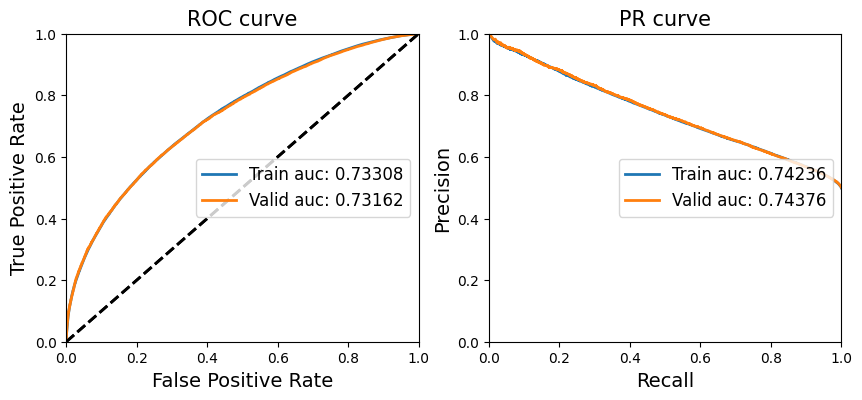

In [95]:
target_proba_sets = predict_proba_4eval_sets(clf, [(X_train, y_train),
                     (X_valid, y_valid)])

fig, metrics_df = evaluation_clf(target_proba_sets, ['Train', 'Valid'], thres_method='f1')

display(metrics_df)

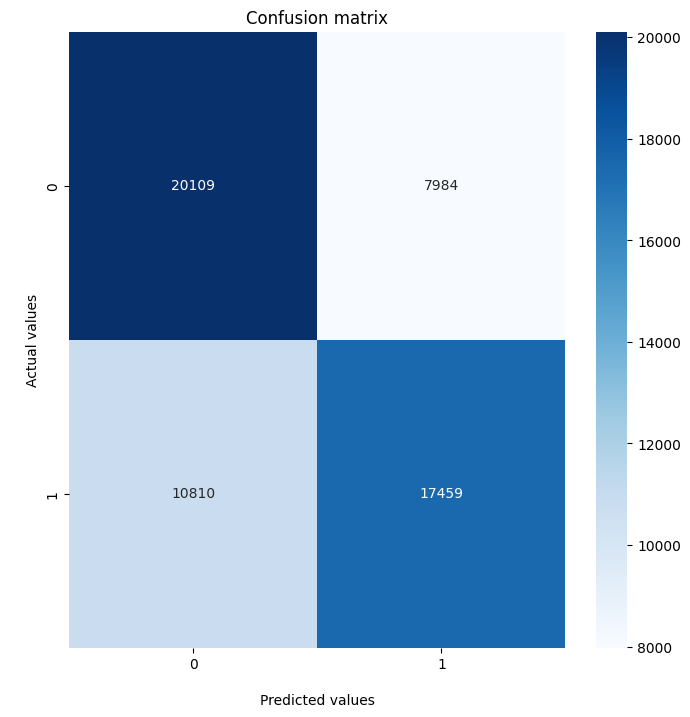

In [96]:
y_pred = clf.predict(X_valid)
plot_confusion(y_valid, y_pred)

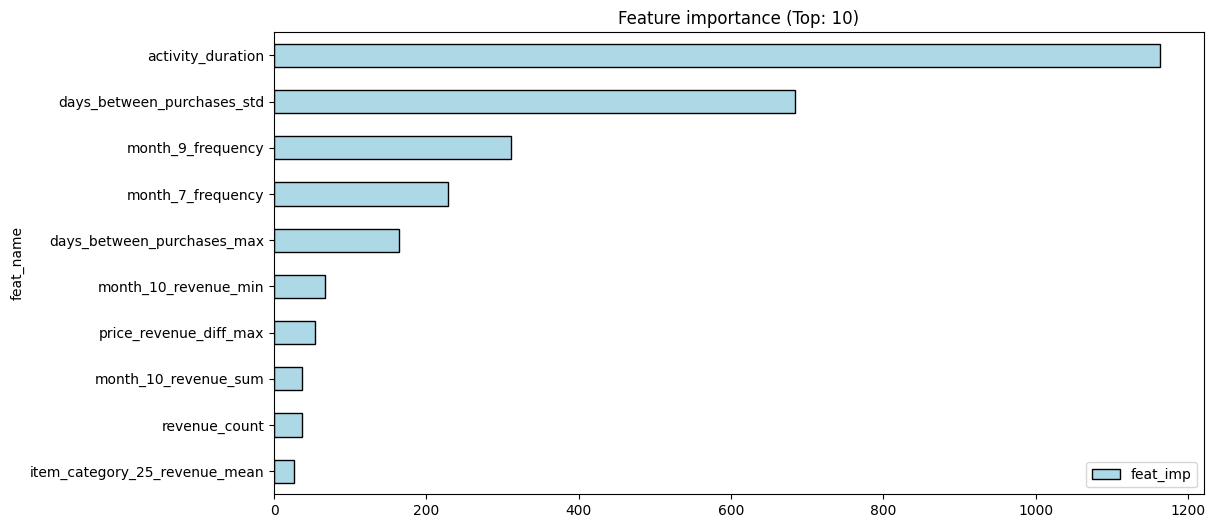

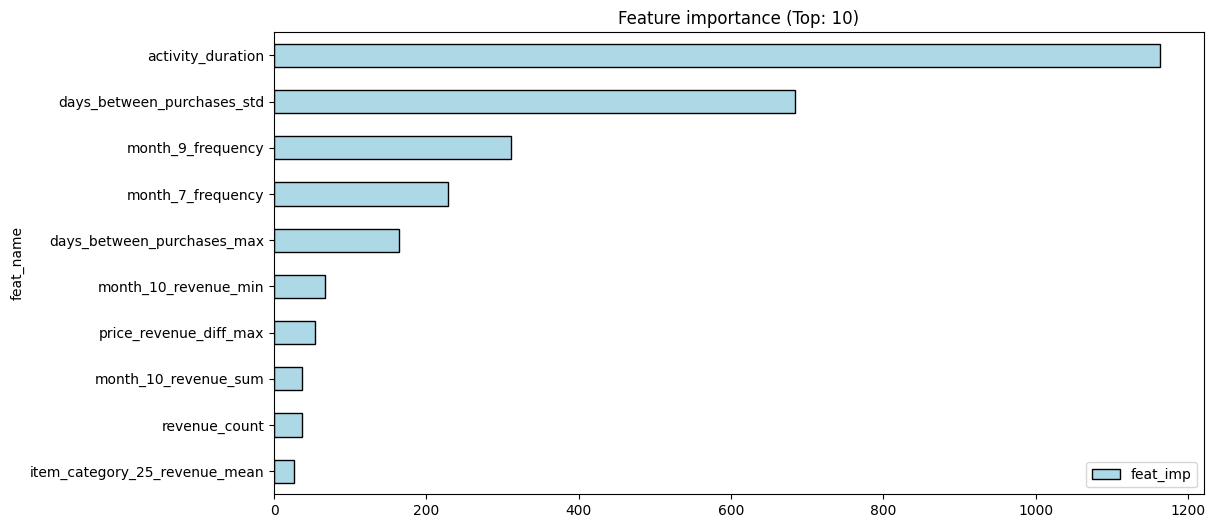

In [97]:
plot_feature_importance(clf, top_n=10)

In [98]:
imp = get_feature_importance(clf)
zero_imp = imp[imp.feat_imp == 0.0].feat_name.values

In [99]:
cols = X_train.drop(columns=zero_imp).columns.to_list()
len(cols)

56

In [100]:
clf = build_cb_model(X_train[cols], y_train,
                     X_valid[cols], y_valid, 
                     cat_features=cat_features, params=lgbm_params)

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.733082,0.374364,0.697482,0.57905,0.876816
1,Valid(OOT),0.731615,0.374102,0.697129,0.57930,0.875128


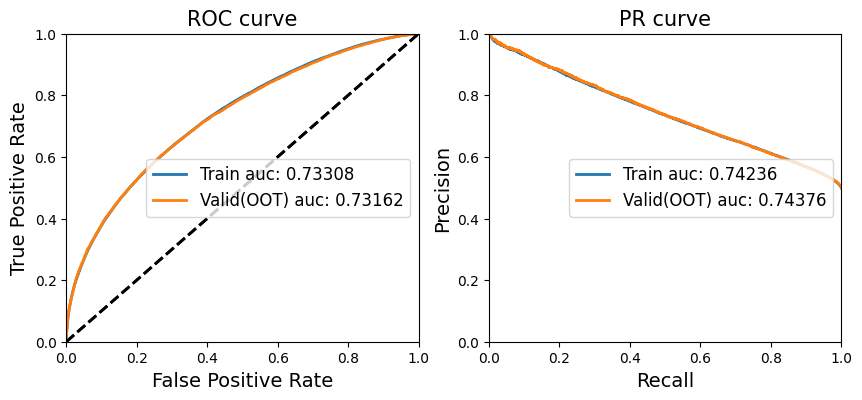

In [101]:
target_proba_sets = predict_proba_4eval_sets(clf, [(X_train[cols], y_train),
                     (X_valid[cols], y_valid)])

fig, metrics_df = evaluation_clf(target_proba_sets, ['Train', 'Valid(OOT)'], thres_method='J')

display(metrics_df)

In [102]:
predictions_test = clf.predict(X_valid[cols])
print(f'f1_test: {f1_score(y_valid, predictions_test)}')
print(f'precision_test: {precision_score(y_valid, predictions_test)}')
print(f'recall_test: {recall_score(y_valid, predictions_test)}')

f1_test: 0.6500968126303248
precision_test: 0.6862005266674528
recall_test: 0.6176023205631611


In [18]:
perm_imp_df, lst_sel_feats = feat_selection_by_permutation(
    X_train[cols], X_valid[cols], 
    y_train, y_valid, lst_feats=list(X_train[cols].columns), 
    model_name='catboost', model_params=lgbm_params, scorer='f1')

/tmp/ipykernel_47/3688796578.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['NORMAL'] = sps.norm.rvs(loc=0, scale=1, size=len(test_df), random_state=seed)
/tmp/ipykernel_47/3688796578.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['UNIFORM'] = sps.uniform.rvs(loc=0, scale=1, size=len(test_df), random_state=seed)
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{al

>> Building model: catboost
>> Done (12.82s)
Start permutation with adding noise feats ...
>> Done (546.14s)
Reduced number of feats: 81 -> 39


/tmp/ipykernel_47/3688796578.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(['NORMAL', 'UNIFORM'], axis=1, inplace=True)


In [19]:
cols = lst_sel_feats.copy()

In [31]:
clf = build_cb_model(X_train[cols], y_train,
                     X_valid[cols], y_valid, 
                     cat_features=cat_features, params=lgbm_params)

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.722223,0.380537,0.695479,0.568791,0.894776
1,Valid(OOT),0.721043,0.385086,0.694289,0.571200,0.884998


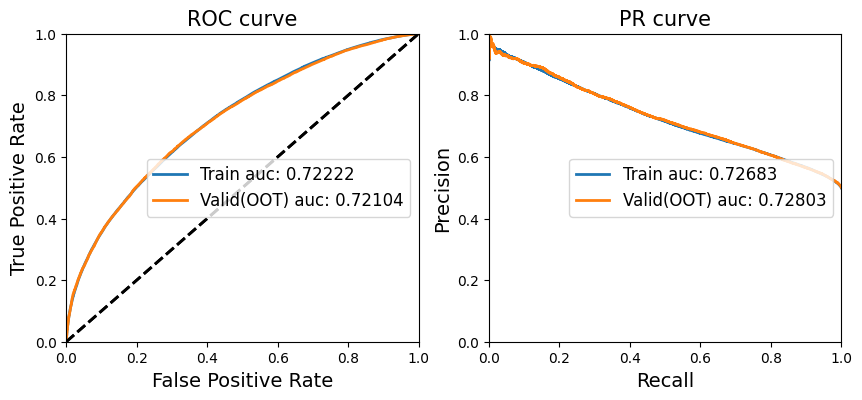

In [32]:
target_proba_sets = predict_proba_4eval_sets(clf, [(X_train[cols], y_train),
                     (X_valid[cols], y_valid)])

fig, metrics_df = evaluation_clf(target_proba_sets, ['Train', 'Valid(OOT)'], thres_method='f1')

display(metrics_df)

In [33]:
predictions_test = clf.predict(X_valid[cols])
print(f'f1_test: {f1_score(y_valid, predictions_test)}')
print(f'precision_test: {precision_score(y_valid, predictions_test)}')
print(f'recall_test: {recall_score(y_valid, predictions_test)}')

f1_test: 0.6462466216837345
precision_test: 0.6728045325779037
recall_test: 0.6217057554211327


In [36]:
clf = build_cb_model(X_train[cols[:5]], y_train,
                     X_valid[cols[:5]], y_valid, 
                     cat_features=cat_features, params=lgbm_params)

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.720797,0.369117,0.695210,0.565329,0.902571
1,Valid(OOT),0.719854,0.374402,0.695255,0.568054,0.895858


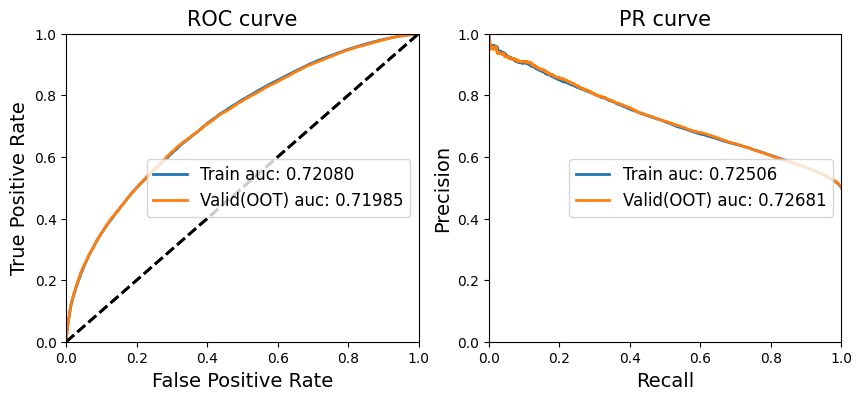

In [37]:
target_proba_sets = predict_proba_4eval_sets(clf, [(X_train[cols[:5]], y_train),
                     (X_valid[cols[:5]], y_valid)]) 

fig, metrics_df = evaluation_clf(target_proba_sets, ['Train', 'Valid(OOT)', 'Test(OOT)'], thres_method='J')

display(metrics_df)

In [52]:
y_proba = clf.predict_proba(X_valid[cols[:5]])[:, 1]

threshold = 0.374402
test_pred = (y_proba < threshold).astype(int)

f1_score(y_valid, test_pred)

0.14671795384154263

In [40]:
y_proba = clf.predict_proba(test[cols[:5]])[:, 1]

threshold = 0.374402
test_pred = (y_proba < threshold).astype(int)

test_pred = clf.predict(test[cols[:5]])

In [43]:
test['pred'] = test_pred

In [44]:
sub = pd.read_csv('/kaggle/input/international-cp/submission.csv', delimiter=';')

In [45]:
sub = sub.merge(test[['pred']], left_on='customer_id', right_on=test.index)

In [46]:
sub['buy_post'] = sub['pred']
sub = sub.drop(columns=['pred'])

In [47]:
sub.buy_post.value_counts()

buy_post
1    89148
0    23186
Name: count, dtype: int64

In [51]:
sub.to_csv('lgbm_selected_5_feats_thres.csv', sep=';', index=False)

In [86]:
y_pred_train = clf.predict(X_train[cols[:5]])
y_pred_test = clf.predict(X_valid[cols[:5]])

In [87]:
import pandas as pd

# Convert y_train to DataFrame
y_train_df = y_train.to_frame()

# Convert y_pred_train to DataFrame
y_pred_train_df = pd.DataFrame(y_pred_train, index=y_train.index, columns=['y_pred_train'])

In [88]:
result = pd.concat([y_train_df, y_pred_train_df], axis=1)


In [89]:
result

,buy_post,y_pred_train
customer_id,,
14923816,0,1
9601170,1,1
8777247,0,0
27848891,1,0
2354165,0,0
...,...,...
35115573,0,0
13849983,1,0
39507237,0,0


In [90]:
mismatched_rows = result[result['buy_post'] != result['y_pred_train']]
mismatched_customer_ids = mismatched_rows.index

In [92]:
len(mismatched_customer_ids)

77526

In [94]:
X_train[X_train.index.isin(mismatched_customer_ids)][cols[:5]]

,revenue_count,days_between_purchases_mean,days_between_purchases_max,month_7_frequency,month_9_frequency
customer_id,,,,,
14923816,14,3.384615,44.0,0,0
27848891,5,4.250000,16.0,0,0
28334057,17,2.562500,24.0,0,0
11171376,6,0.600000,3.0,0,0
43676159,19,1.055556,17.0,0,0
...,...,...,...,...,...
39080988,9,3.500000,17.0,0,0
26273336,16,2.400000,20.0,0,0
18228879,14,1.153846,10.0,0,0


In [54]:
get_feature_importance(clf)

,feat_name,feat_imp
0,days_between_purchases_mean,1145
1,revenue_count,995
2,days_between_purchases_max,399
3,month_9_frequency,290
4,month_7_frequency,170
